### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

### Ground truth

In [4]:
protons = [10, 10, 8]

In [5]:
molar_proportions = [0.4855, 0.2427, 0.2718]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.5134089082526119, 0.25665157988240767, 0.22993951186498032]

### Loading the data

In [7]:
official_names = ['Leucine', 'Isoleucine', 'Valine']

In [8]:
mix = np.loadtxt(os.getcwd()+'/BCAA_aligned.csv', skiprows=0, usecols=range(2), 
                      delimiter=',',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library_BCAA_aligned.csv', skiprows=1, usecols=range(4),
                      delimiter=',', dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [9]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [10]:
spectra = []
for comp_ints in components_ints:
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [11]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


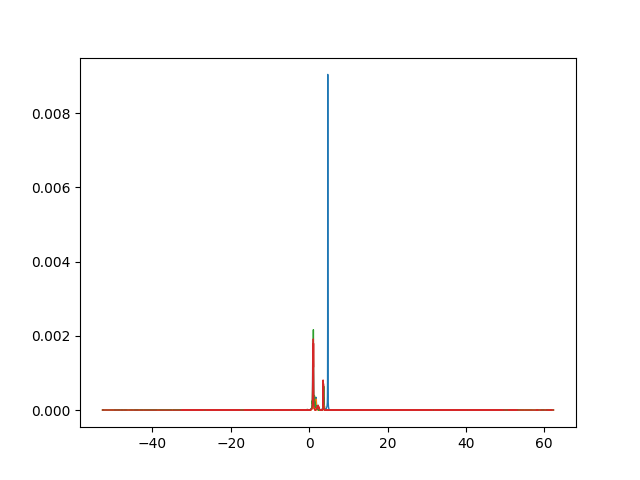

In [12]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)

### Alignment

In [13]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        return (min_of_min - epsilon)*(-1)
    else:
        return(0)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
shift_coef = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

<IPython.core.display.Javascript object>


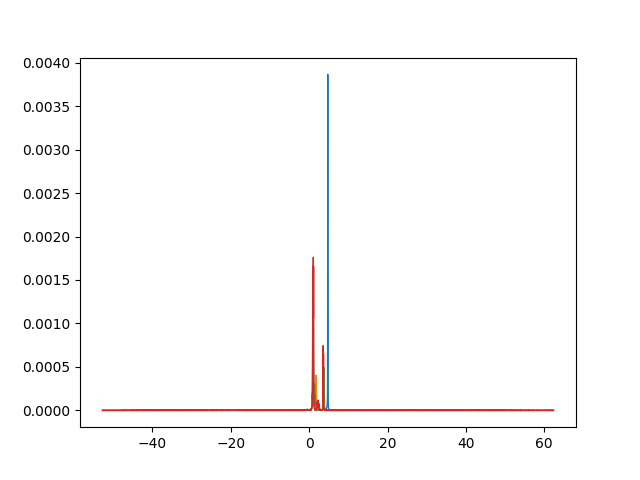

In [26]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)

### Removing unnecessary data points

In [27]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [28]:
#0.1, 4 without solvent peak
#0.1, 5.4
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 0.1, 4)

In [29]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [30]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [31]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [32]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [33]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [34]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [35]:
official_names

['Leucine', 'Isoleucine', 'Valine']

In [36]:
labels = official_names + ['Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


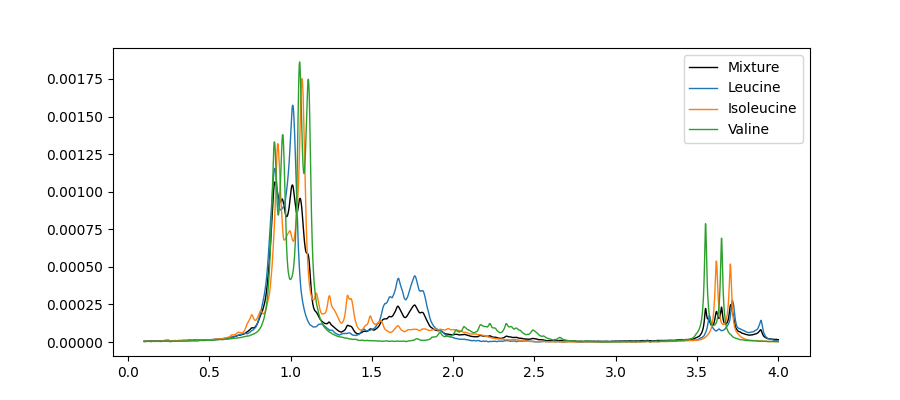

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True) 
ax.legend()

### Finding best kappa

In [38]:
import time
import pandas as pd
import pulp

In [39]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [40]:
# list_of_estimation_results = []
# list_of_noise_prop = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     fixed_kappa_noise_prop = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, spectra, 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         fixed_kappa_noise_prop.append(estimation['proportion_of_noise_in_components'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#         print(estimation['proportion_of_noise_in_components'])
#     list_of_estimation_results.append(fixed_kappa)
#     list_of_noise_prop.append(fixed_kappa_noise_prop)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-10


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estimation for 0.01 and 0.01 done
It took: 3.1450581550598145 seconds.
[0.5051788819040006, 0.24496670271500035, 0.2232254164600003]
0.010273088277000015
Estimation for 0.01 and 0.02 done
It took: 3.1543521881103516 seconds.
[0.5020238314870007, 0.2370750572540003, 0.2277801681270003]
0.004169678701000005
Estimation for 0.01 and 0.03 done
It took: 3.3186826705932617 seconds.
[0.5001555036120007, 0.2386726470270003, 0.2248306077220003]
0.0017992386870000023
Estimation for 0.01 and 0.04 done
It took: 3.603468418121338 seconds.
[0.4997722414660007, 0.2380277798250003, 0.22419786129300032]
0.0009223102730000012
Estimation for 0.01 and 0.05 done
It took: 3.7856714725494385 seconds.
[0.5001335166560007, 0.2349590440030003, 0.2251706277350003]
0.0
Estimation for 0.01 and 0.060000000000000005 done
It took: 3.527226448059082 seconds.
[0.5001335166560007, 0.2349590440030003, 0.2251706277350003]
0.0
Estimation for 0.01 and 0.06999999999999999 done
It took: 3.5068769454956055 seconds.
[0.500133516

Estimation for 0.02 and 0.29000000000000004 done
It took: 3.806452989578247 seconds.
[0.5020065132080007, 0.24840263432800033, 0.21653835728300028]
0.0
Estimation for 0.02 and 0.3 done
It took: 3.843700408935547 seconds.
[0.5020065132080007, 0.24840263432800033, 0.21653835728300028]
0.0
Estimation for 0.03 and 0.01 done
It took: 3.0533804893493652 seconds.
[0.5026129744590007, 0.24686264680100034, 0.23314131511700031]
0.025194792036000033
Estimation for 0.03 and 0.02 done
It took: 3.1113836765289307 seconds.
[0.5026681926590006, 0.25001515986500034, 0.2247542497140003]
0.012120708280000015
Estimation for 0.03 and 0.03 done
It took: 3.3327460289001465 seconds.
[0.5027860735520007, 0.24936105614500034, 0.2224742850650003]
0.006775169933000009
Estimation for 0.03 and 0.04 done
It took: 3.243281364440918 seconds.
[0.5027157815230007, 0.25055053867200033, 0.2190451453190003]
0.003211859504000004
Estimation for 0.03 and 0.05 done
It took: 3.1606040000915527 seconds.
[0.5028736163510007, 0.25

Estimation for 0.04 and 0.26 done
It took: 4.192236423492432 seconds.
[0.5043346902790007, 0.25437775196800033, 0.2123859711680003]
0.0
Estimation for 0.04 and 0.27 done
It took: 4.186346530914307 seconds.
[0.5043346902790007, 0.25437775196800033, 0.2123859711680003]
0.0
Estimation for 0.04 and 0.28 done
It took: 4.186798095703125 seconds.
[0.5043346902790007, 0.25437775196800033, 0.2123859711680003]
0.0
Estimation for 0.04 and 0.29000000000000004 done
It took: 3.9863922595977783 seconds.
[0.5043346902790007, 0.25437775196800033, 0.2123859711680003]
0.0
Estimation for 0.04 and 0.3 done
It took: 3.979233980178833 seconds.
[0.5043346902790007, 0.25437775196800033, 0.2123859711680003]
0.0
Estimation for 0.05 and 0.01 done
It took: 3.34678053855896 seconds.
[0.49679199062400065, 0.24722816610800033, 0.24273574489700034]
0.03849085542900005
Estimation for 0.05 and 0.02 done
It took: 3.169687271118164 seconds.
[0.5000760933010007, 0.24869542990700033, 0.2329253327520003]
0.020719132639000028

Estimation for 0.060000000000000005 and 0.2 done
It took: 3.613382339477539 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 3.636054277420044 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.22 done
It took: 3.6249189376831055 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.23 done
It took: 3.605027675628662 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 3.6308252811431885 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.25 done
It took: 3.636202335357666 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
0.0
Estimation for 0.060000000000000005 and 0.26 done
It took

Estimation for 0.08 and 0.12 done
It took: 3.2821547985076904 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.13 done
It took: 3.3816254138946533 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.14 done
It took: 3.353071928024292 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.15000000000000002 done
It took: 3.3226850032806396 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.16 done
It took: 3.4645347595214844 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.17 done
It took: 3.35699725151062 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 and 0.18000000000000002 done
It took: 3.4934778213500977 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
0.0
Estimation for 0.08 a

Estimation for 0.09999999999999999 and 0.08 done
It took: 3.312570095062256 seconds.
[0.5041356372890007, 0.2584986244000003, 0.2135055152670003]
0.0031069651720000042
Estimation for 0.09999999999999999 and 0.09 done
It took: 3.3118836879730225 seconds.
[0.5044324037310006, 0.25876141910500033, 0.21280185721600028]
0.0026803314330000037
Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 3.352311611175537 seconds.
[0.5048759593600006, 0.2590718961500003, 0.2119300643470003]
0.002241968873000003
Estimation for 0.09999999999999999 and 0.11 done
It took: 3.4214134216308594 seconds.
[0.5054215317140006, 0.25945426545000033, 0.21059240482000027]
0.0015765518120000022
Estimation for 0.09999999999999999 and 0.12 done
It took: 3.496211290359497 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
0.0
Estimation for 0.09999999999999999 and 0.13 done
It took: 3.4609897136688232 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
0.0
Est

Estimation for 0.12 and 0.02 done
It took: 3.5915369987487793 seconds.
[0.4966974409350007, 0.24346017222900032, 0.24819835229000034]
0.039826831968000055
Estimation for 0.12 and 0.03 done
It took: 3.942830801010132 seconds.
[0.49325759334100067, 0.24714012431100033, 0.24688234316400035]
0.033163169513000045
Estimation for 0.12 and 0.04 done
It took: 3.986243963241577 seconds.
[0.4949533358670007, 0.2502602362430003, 0.23922544074400032]
0.024675454929000033
Estimation for 0.12 and 0.05 done
It took: 3.4751014709472656 seconds.
[0.49876952167000066, 0.25395664879800034, 0.2284264707490003]
0.01565432238800002
Estimation for 0.12 and 0.060000000000000005 done
It took: 3.50244140625 seconds.
[0.5020306745370007, 0.25542424049300033, 0.2215612545540003]
0.009933598963000013
Estimation for 0.12 and 0.06999999999999999 done
It took: 3.42368483543396 seconds.
[0.5038107861380007, 0.2565071313500003, 0.21717023105100028]
0.006070851700000008
Estimation for 0.12 and 0.08 done
It took: 3.515546

Estimation for 0.13 and 0.28 done
It took: 4.367264986038208 seconds.
[0.5077237076720007, 0.26061472853200035, 0.2070648032400003]
0.0
Estimation for 0.13 and 0.29000000000000004 done
It took: 4.071300506591797 seconds.
[0.5077237076720007, 0.26061472853200035, 0.2070648032400003]
0.0
Estimation for 0.13 and 0.3 done
It took: 4.291700839996338 seconds.
[0.5077237076720007, 0.26061472853200035, 0.2070648032400003]
0.0
Estimation for 0.14 and 0.01 done
It took: 4.094207525253296 seconds.
[0.5369930630550007, 0.20974104036700028, 0.24554805408400032]
0.07955913728300011
Estimation for 0.14 and 0.02 done
It took: 3.793226718902588 seconds.
[0.49990123461200064, 0.24017298622500033, 0.24884842975500032]
0.04231047972000006
Estimation for 0.14 and 0.03 done
It took: 4.0929365158081055 seconds.
[0.49325725365800066, 0.24581139561300033, 0.24898048678500034]
0.03551801992400005
Estimation for 0.14 and 0.04 done
It took: 3.9276609420776367 seconds.
[0.4925458648470007, 0.24840830931300034, 0.2

Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 3.8474059104919434 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.22 done
It took: 4.006982803344727 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.23 done
It took: 3.8828535079956055 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 3.810856819152832 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.25 done
It took: 3.842787981033325 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.26 done
It took: 4.036647796630859 seconds.
[0.5080659333270007, 0.26069292057200033, 0.20674170765600028]
0.0
Estimation for 0.15000000000000002 and 0.27 done
It took

Estimation for 0.17 and 0.15000000000000002 done
It took: 3.5926296710968018 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.16 done
It took: 3.6389572620391846 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.17 done
It took: 3.6998372077941895 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.18000000000000002 done
It took: 3.589043140411377 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.19 done
It took: 3.548417568206787 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.2 done
It took: 3.476600408554077 seconds.
[0.5084755376610006, 0.26057136155900035, 0.20654723824300028]
0.0
Estimation for 0.17 and 0.21000000000000002 done
It took: 3.4944522380828857 seconds.
[0.5084755376610006, 0.26057136155900035, 0.2065472382430002

Estimation for 0.19 and 0.08 done
It took: 3.5545709133148193 seconds.
[0.5029781948820007, 0.2524821891750003, 0.2250950433830003]
0.012484061586000017
Estimation for 0.19 and 0.09 done
It took: 3.5014443397521973 seconds.
[0.5046148538570007, 0.25504702594200035, 0.2193877018430003]
0.008685101999000012
Estimation for 0.19 and 0.09999999999999999 done
It took: 3.4755778312683105 seconds.
[0.5059038956520007, 0.2570899860460003, 0.2148449948080003]
0.005600762330000008
Estimation for 0.19 and 0.11 done
It took: 3.4962000846862793 seconds.
[0.5066759199000007, 0.25869375692500035, 0.21158758146900028]
0.0034485006250000046
Estimation for 0.19 and 0.12 done
It took: 3.6374661922454834 seconds.
[0.5071901722810007, 0.25912255233600034, 0.21029135896300027]
0.0025395187570000036
Estimation for 0.19 and 0.13 done
It took: 3.5460846424102783 seconds.
[0.5075717251230006, 0.25920197404000034, 0.20966745752500027]
0.0020635018840000027
Estimation for 0.19 and 0.14 done
It took: 3.630273580551

Estimation for 0.21000000000000002 and 0.04 done
It took: 3.8716509342193604 seconds.
[0.49326207727000065, 0.24503831678900034, 0.2500332246330003]
0.03610341176000005
Estimation for 0.21000000000000002 and 0.05 done
It took: 3.5768494606018066 seconds.
[0.49207473483600067, 0.24569184366200034, 0.25018217812600035]
0.03372265653700004
Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 4.015517711639404 seconds.
[0.4926528911410007, 0.24498928186400035, 0.24998019280700035]
0.03197177511900004
Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 3.947791814804077 seconds.
[0.4960918299070007, 0.24606227359100033, 0.24351478466600032]
0.025887773618000036
Estimation for 0.21000000000000002 and 0.08 done
It took: 3.4800233840942383 seconds.
[0.5002212319660007, 0.24864744587300033, 0.2340752521490003]
0.018550369833000024
Estimation for 0.21000000000000002 and 0.09 done
It took: 3.2683680057525635 seconds.
[0.5035046543110007, 0.252954083000000

Estimation for 0.22 and 0.26 done
It took: 3.5014021396636963 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
0.0
Estimation for 0.22 and 0.27 done
It took: 3.3735368251800537 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
0.0
Estimation for 0.22 and 0.28 done
It took: 3.4309403896331787 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
0.0
Estimation for 0.22 and 0.29000000000000004 done
It took: 3.1636786460876465 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
0.0
Estimation for 0.22 and 0.3 done
It took: 3.234753131866455 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
0.0
Estimation for 0.23 and 0.01 done
It took: 5.959126949310303 seconds.
[0.5599159789120007, 0.18722376829700024, 0.24767794448200034]
0.10972235397100015
Estimation for 0.23 and 0.02 done
It took: 5.035949945449829 seconds.
[0.5257436761750006, 0.21720538182300028, 0.24959243316100033]
0.065578366

Estimation for 0.24000000000000002 and 0.19 done
It took: 3.4298229217529297 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.2 done
It took: 3.4476003646850586 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 3.487663984298706 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.22 done
It took: 3.236846923828125 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.23 done
It took: 3.3951382637023926 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 3.4213149547576904 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
0.0
Estimation for 0.24000000000000002 and 0.25 done
It took: 3.3

Estimation for 0.26 and 0.13 done
It took: 3.5576860904693604 seconds.
[0.5070196771910007, 0.25623885096100035, 0.21465773730900028]
0.005190344114000007
Estimation for 0.26 and 0.14 done
It took: 3.261620044708252 seconds.
[0.5079614975580007, 0.25758307219200033, 0.21149508021200028]
0.003009154349000004
Estimation for 0.26 and 0.15000000000000002 done
It took: 3.2222445011138916 seconds.
[0.5083911084650007, 0.25782577101100035, 0.21056585666200028]
0.002324018965000003
Estimation for 0.26 and 0.16 done
It took: 3.4447579383850098 seconds.
[0.5087499373010007, 0.25794148718700033, 0.2099148780220003]
0.0018437303410000023
Estimation for 0.26 and 0.17 done
It took: 3.6164987087249756 seconds.
[0.5090872496620007, 0.25807604274500034, 0.20928342367700029]
0.001394830738000002
Estimation for 0.26 and 0.18000000000000002 done
It took: 3.7067697048187256 seconds.
[0.5097388113530007, 0.2586869280480003, 0.20754778531600027]
0.00018194064500000025
Estimation for 0.26 and 0.19 done
It too

Estimation for 0.28 and 0.08 done
It took: 3.4088687896728516 seconds.
[0.49382108508800066, 0.24213112955500032, 0.2516879412200003]
0.03086527257400004
Estimation for 0.28 and 0.09 done
It took: 3.3623549938201904 seconds.
[0.49552519599800066, 0.24211884924400034, 0.24940101888600033]
0.028951288491000038
Estimation for 0.28 and 0.09999999999999999 done
It took: 3.3320796489715576 seconds.
[0.4991339407800007, 0.24506881982300033, 0.24054384189400033]
0.022739573426000033
Estimation for 0.28 and 0.11 done
It took: 3.2178311347961426 seconds.
[0.5023492290440007, 0.24927985708900033, 0.2306484929290003]
0.01622257677300002
Estimation for 0.28 and 0.12 done
It took: 3.472687005996704 seconds.
[0.5048893032760007, 0.2525194687300003, 0.2227652475460003]
0.010720014373000014
Estimation for 0.28 and 0.13 done
It took: 3.5644237995147705 seconds.
[0.5065463124940006, 0.25487490654500033, 0.21724835338800028]
0.00693362006200001
Estimation for 0.28 and 0.14 done
It took: 3.5518696308135986

Estimation for 0.29000000000000004 and 0.3 done
It took: 3.462254047393799 seconds.
[0.5102458346300006, 0.25833936820600034, 0.20739083370800027]
0.0
Estimation for 0.3 and 0.01 done
It took: 7.163629770278931 seconds.
[0.5692122939920008, 0.17477798040800022, 0.2524932662540003]
0.12874632106900016
Estimation for 0.3 and 0.02 done
It took: 6.305635929107666 seconds.
[0.5375908720800007, 0.20660860552000027, 0.25010867547900034]
0.0756649020090001
Estimation for 0.3 and 0.03 done
It took: 4.891411304473877 seconds.
[0.5177094251590006, 0.2206032183210003, 0.25431910564100035]
0.06157344613100008
Estimation for 0.3 and 0.04 done
It took: 4.3549582958221436 seconds.
[0.49756590559400066, 0.2359695106920003, 0.2569834808960003]
0.04616407249500006
Estimation for 0.3 and 0.05 done
It took: 3.7616381645202637 seconds.
[0.49431427331100064, 0.2392907387240003, 0.2558708688350003]
0.039592454926000054
Estimation for 0.3 and 0.060000000000000005 done
It took: 3.781792640686035 seconds.
[0.493

In [40]:
# list_of_dataframes_with_results = []
# for component_number in range(len(spectra)):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [41]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [42]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [43]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [44]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [45]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [46]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate (rows): kappa,
#second coordinate (columns): kappa_prime

In [47]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [48]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [49]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [50]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [51]:
all_components_results_both.min().min()

0.020531963323617425

In [52]:
all_components_results_both[0.11][0.27]

0.020531963323617425

### Saving preprocessed spectra

In [55]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')